In [1]:
import sys
sys.path

['D:\\bio\\jupyter_code\\BRCA',
 'D:\\anaconda\\envs\\paste\\python310.zip',
 'D:\\anaconda\\envs\\paste\\DLLs',
 'D:\\anaconda\\envs\\paste\\lib',
 'D:\\anaconda\\envs\\paste',
 '',
 'C:\\Users\\23147\\AppData\\Roaming\\Python\\Python310\\site-packages',
 'D:\\anaconda\\envs\\paste\\lib\\site-packages',
 'D:\\anaconda\\envs\\paste\\lib\\site-packages\\win32',
 'D:\\anaconda\\envs\\paste\\lib\\site-packages\\win32\\lib',
 'D:\\anaconda\\envs\\paste\\lib\\site-packages\\Pythonwin']

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import paste as pst
import ot

In [3]:
sample_names = ["bc1160920F","bc1142243F"]
input_dir = 'G:/dataset/3_BRCA/input/'
output_dir = 'G:/dataset/3_BRCA/output/paste/'
experiment_name = 'BRCA'

# Load Slices

In [4]:
adata_list = []
meta = list()
for dataset in sample_names:
    print(dataset)
    
    # adata = sc.read_visium(input_dir + dataset)
    # adata.var_names_make_unique()
    # adata.obs_names_make_unique()
    adata = sc.read_h5ad(input_dir + dataset+'.h5ad')

    df = adata.obs[['x','y']].astype('float32')
    adata.obsm['spatial'] = df.values

    # adata.obs['annotation'] = adata.obs['ClusterName']
    # adata.obs = adata.obs[~pd.isna(adata.obs['x'])]
    # adata = adata.drop(adata.loc[pd.isna(adata.obs['x'])])
    # adata.obs= adata.obs[~adata.obs.ClusterName.str.contains("NA")]
    # adata = adata[~pd.isna(adata.obs['x'])]
    
    meta.extend(adata.obs['Classification'].tolist())
    
    sc.pp.filter_genes(adata, min_counts = 15)
    sc.pp.filter_cells(adata, min_counts = 100)
    
    adata_list.append(adata)

celltypes = pd.Series(data=meta).astype("category").value_counts().index.tolist()
n_colors = len(celltypes)
print(celltypes)
print(n_colors)
print(adata_list)

bc1160920F
bc1142243F
['Invasive cancer + stroma + lymphocytes', 'Stroma', 'Necrosis', 'Normal glands + lymphocytes', 'Lymphocytes', 'Artefact', 'Adipose tissue', 'DCIS', 'TLS', 'Cancer trapped in lymphocyte aggregation', '']
11
[AnnData object with n_obs × n_vars = 4895 × 17494
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'Classification', 'batch', 'x', 'y', 'imagerow', 'imagecol', 'n_counts'
    var: 'features', 'n_counts'
    obsm: 'spatial', AnnData object with n_obs × n_vars = 4781 × 16877
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'Classification', 'batch', 'x', 'y', 'imagerow', 'imagecol', 'n_counts'
    var: 'features', 'n_counts'
    obsm: 'spatial']


In [5]:
for adata in adata_list:
    print(adata.obs)

                    orig.ident  nCount_Spatial  nFeature_Spatial  \
TGTTGGCTGGCGGAAG-1           0          3685.0              1441   
GCATCCTCTCCTATTA-1           0          4526.0              1829   
GCGAGGGACTGCTAGA-1           0          4171.0              1668   
TGGTACCGGCACAGCC-1           0          4722.0              1837   
GCGCGTTTAAATCGTA-1           0          5547.0              2217   
...                        ...             ...               ...   
AGAGTCTTAATGAAAG-1           0         21320.0              5749   
GAACGTTTGTATCCAC-1           0          6903.0              2945   
ATTGAATTCCCTGTAG-1           0         11408.0              4043   
TACCTCACCAATTGTA-1           0          6722.0              2651   
AGTCGAATTAGCGTAA-1           0         11652.0              3985   

                                            Classification       batch   x  \
TGTTGGCTGGCGGAAG-1                          Adipose tissue  bc1160920F   1   
GCATCCTCTCCTATTA-1         

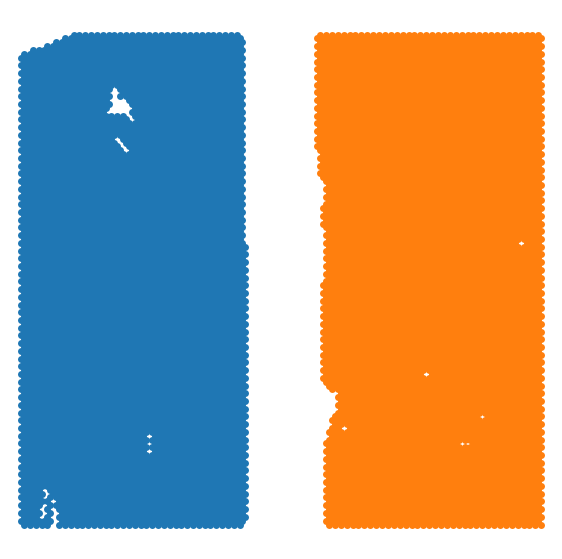

In [6]:
import seaborn as sns
slice_colors = sns.color_palette(n_colors = n_colors).as_hex()

fig, axs = plt.subplots(1, 2,figsize=(7,7))
i = 0
for adata in adata_list:
    pst.plot_slice(adata,slice_colors[i],ax=axs[int(i%2)])
    i = i + 1
    
plt.show()

In [ ]:
for adata in adata_list:
    sc.pl.spatial(adata, color = "Classification", spot_size = 1)

In [ ]:
# import seaborn as sns
# import numpy as np
# import matplotlib.pyplot as plt

# # seaborn.color_palette(palette = None, n_colors = None, desat = None)

# current_palette = sns.color_palette(n_colors = 6)
# sns.palplot(current_palette)
# plt.show()
# print(sns.color_palette(n_colors = 6).as_hex())

# run PASTE

In [ ]:
import time
start = time.time()

pis = []
for i in range(len(adata_list)-1):
    pi_temp = pst.pairwise_align(adata_list[i], adata_list[i+1], backend = ot.backend.TorchBackend(), use_gpu = True)
    pis.append(pi_temp)
    
print('Runtime: ' + str(time.time() - start))

In [ ]:
print(pis)

In [ ]:
# To visualize the alignment you can stack the slices 
# according to the alignment pi
new_slices = pst.stack_slices_pairwise(adata_list, pis)

plt.figure(figsize=(7,7))
for i in range(len(new_slices)):
    pst.plot_slice(new_slices[i],slice_colors[i],s=400)
plt.legend(handles=[mpatches.Patch(color=slice_colors[0], label='1'),mpatches.Patch(color=slice_colors[1], label='2')])
plt.gca().invert_yaxis()
plt.axis('off')
plt.show()

In [ ]:
# slice_colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3']

fig, axs = plt.subplots(1, 1,figsize=(7,7))
for i in range(len(adata_list)-1):
    pst.plot_slice(new_slices[i], slice_colors[i])
    pst.plot_slice(new_slices[i+1], slice_colors[i+1])
    
# fig.delaxes(axs[1,1])
plt.show()

In [ ]:
type(adata_list[0].obsm['spatial'])

In [ ]:
# save coor
new_coord = new_slices[0].obsm['spatial']
cells = new_slices[0].obs_names
for i in range(1, len(adata_list)):
    new_coord = np.vstack((new_coord, new_slices[i].obsm['spatial']))
    cells = np.hstack((cells, new_slices[i].obs_names))

# new_coord=np.vstack((new_slices[0].obsm['spatial'],
#                     new_slices[1].obsm['spatial']))
# cells=np.hstack((new_slices[0].obs_names,new_slices[1].obs_names))

new_coord=pd.DataFrame(new_coord,index=cells,columns=['x','y'])
new_coord.to_csv(output_dir + "paste_coord_" + experiment_name + ".csv")

## center slice mode

In [7]:
slices = adata_list

initial_slice = slices[0].copy()
lmbda = len(slices)*[1/len(slices)]

pst.filter_for_common_genes(slices)

# b = []
# for i in range(len(slices)):
#     b.append(pst.match_spots_using_spatial_heuristic(slices[0].X.todense(), slices[i].X.todense()))

Filtered all slices for common genes. There are 15884 common genes.


In [8]:
type(slices[0].X.dtype)

numpy.dtype[float64]

In [10]:
import time
start = time.time()
## Possible to pass in an initial pi (as keyword argument pis_init) 
## to improve performance, see Tutorial.ipynb notebook for more details.
# center_slice, pis = pst.center_align(initial_slice, slices, lmbda) 

center_slice, pis = pst.center_align(initial_slice, slices, lmbda, random_seed = 5, backend = ot.backend.TorchBackend(), use_gpu = True)
# center_slice, pis = pst.center_align(initial_slice, slices, lmbda, pis_init = b, backend = ot.backend.TorchBackend(), use_gpu = True) 

print('Runtime: ' + str(time.time() - start))

gpu is available, using gpu.
Filtered all slices for common genes. There are 15884 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem.


D:\anaconda\envs\paste\lib\site-packages\ot\lp\__init__.py:354: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
D:\anaconda\envs\paste\lib\site-packages\ot\lp\__init__.py:354: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


Solving Center Mapping NMF Problem.


D:\anaconda\envs\paste\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Objective  -601.7183718858283
Difference: 601.7183718858283

Iteration: 1
Solving Pairwise Slice Alignment Problem.


D:\anaconda\envs\paste\lib\site-packages\ot\lp\__init__.py:354: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
D:\anaconda\envs\paste\lib\site-packages\ot\lp\__init__.py:354: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


Solving Center Mapping NMF Problem.


D:\anaconda\envs\paste\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Objective  77.50057428647983
Difference: 679.2189461723082

Iteration: 2
Solving Pairwise Slice Alignment Problem.


D:\anaconda\envs\paste\lib\site-packages\ot\lp\__init__.py:354: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
D:\anaconda\envs\paste\lib\site-packages\ot\lp\__init__.py:354: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


Solving Center Mapping NMF Problem.


D:\anaconda\envs\paste\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Objective  77.50060671472089
Difference: 3.2428241055981744e-05

Runtime: 2336.1266145706177


In [11]:
W = center_slice.uns['paste_W']
H = center_slice.uns['paste_H']

In [12]:
print(type(W))
print(type(H))
print(W)
print(H)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[[1.34134868e+00 4.09314181e-01 3.31544299e-01 ... 7.43792610e-02
  4.22425560e-02 5.01480946e-02]
 [8.01287260e-01 2.50007976e-01 3.52156872e-01 ... 9.55946295e-03
  5.60264953e-02 1.65289224e-02]
 [2.10204907e+00 5.76974481e-01 2.39746948e-01 ... 8.45686701e-03
  3.11089081e-02 1.14988404e-01]
 ...
 [1.67683348e-01 8.94229749e-02 2.99390895e-01 ... 1.50242985e-03
  9.48735669e-04 2.30932616e-02]
 [1.80576818e-01 5.97577765e-02 2.16273818e-01 ... 6.79846985e-05
  6.06488928e-08 2.32356666e-02]
 [6.85840687e-02 1.23232852e-02 3.24159739e-01 ... 8.96597553e-04
  7.42940420e-06 2.86168944e-04]]
[[8.99561644e-07 8.68127496e-07 3.64639560e-02 ... 4.71558459e-03
  2.31397011e-03 1.15692516e-02]
 [1.27446924e-09 2.16176261e-04 2.53058947e-05 ... 2.54801052e-11
  7.31210224e-08 3.04068211e-02]
 [5.79728448e-04 6.12770374e-11 2.55759096e-02 ... 4.70679868e-03
  4.86602672e-03 8.34919384e-03]
 ...
 [9.27505339e-04 3.19332546e-03 1.76884252e-02 ...

In [13]:
print(W.shape)
print(H.shape)

(4895, 15)
(15, 15884)


In [14]:
np.savetxt(output_dir + experiment_name +"_W.csv", W, delimiter=",")
np.savetxt(output_dir + experiment_name +"_H.csv", H, delimiter=",")

In [15]:
center, new_slices = pst.stack_slices_center(center_slice, slices, pis)

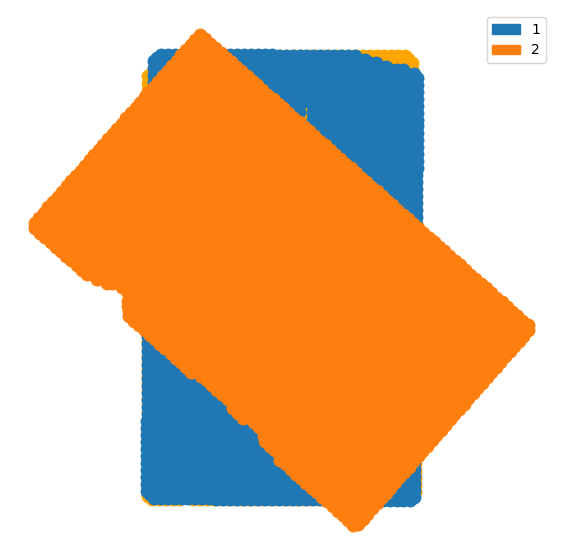

In [16]:
center_color = 'orange'
# slices_colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3']
slice_colors = sns.color_palette(n_colors = n_colors).as_hex()

plt.figure(figsize=(7,7))
pst.plot_slice(center,center_color,s=400)
for i in range(len(new_slices)):
    pst.plot_slice(new_slices[i],slice_colors[i],s=400)

plt.legend(handles=[mpatches.Patch(color=slice_colors[0], label='1'),mpatches.Patch(color=slice_colors[1], label='2')])
plt.gca().invert_yaxis()
plt.axis('off')
plt.show()

In [ ]:
# center_color = 'orange'
# # slice_colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3']

# fig, axs = plt.subplots(1, 1,figsize=(7,7))
# for i in range(len(new_slices)):
#     pst.plot_slice(center,center_color,ax=axs[int(i/2),int(i%2)])
#     pst.plot_slice(new_slices[i],slice_colors[i],ax=axs[int(i/2),int(i%2)])
# plt.show()